In [2]:
! conda install matplotlib -y

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done


# CH2018 datasets from the National Centre for Climate Services NCCS

We provide this small notebook as a short description of the provided data, how and where to access it and how to use it.

The [CH2018 scenarios](https://www.nccs.admin.ch/nccs/en/home/data-and-media-library/data/ch2018---climate-scenarios-for-switzerland.html) are based on the EURO-CORDEX climate projections. These consist of a large number of transient regional climate scenarios carried out by different combinations of global and regional climate models and assuming three different greenhouse gas scenarios. We provide the data for one combination of a global and regional climate model. These localized CH2018 datasets consist of transient daily time series for the period 1981 - 2099 for several variables at individual Swiss stations (DAILY-LOCAL) and on a regular 2km grid covering the area of Switzerland (DAILY-GRIDDED). For more details, [see](/documentation/CH2018_Guide2Data_Hackzh.pdf) the documentation of the localized CH2018 datasets.

## Accessing the source data

We provide the source data on a publicly available amazon s3 bucket at the following location: [https://hackzurich2022.hack-with-admin.ch/]

Since the data lies on a public bucket, the setup is straightforward: create a folder in which you want to mount the bucket.

## Data location and format

### Data organization

The data is organized in two main categories:
* The per station data, in `source/nccs-ch2018/QMStations/`, is data for each individual station listed in the `source/meta/stations_CH2018_meta.txt` file. The per station data is available in NetCDF format. There is one further subdirectory per variable and the individual station files are ziped together. The naming convention is as follows:
    `source/nccs-ch2018/QMStations/CH2018_[VARIABLE]_[TODO_CHOOSE_ONE]_EUR11_[EMISSION_SCENARIO]_QMstations_1981-2099_nc.zip`.

* The grid data, in `source/ncss-ch2018/QMGrid/`, is gridded data for all of Switzerland. The files contain projections on a regular 2-by-2 km grid covering Switzerland. The data is also in NetCDF format. Again, there is one further subdirectory per variable and the individual files have the following naming convention:
    `source/nccs-ch2018/QMgrid/[VARIABLE]/CH2018_[VARIABLE]_[TODO_CHOOSE_ONE]_EUR11_[EMISSION_SCENARIO]_QMgrid_1981-2099.nc`.
    
* Meta data: The `source/meta/stations_CH2018_meta.txt` contains station related informations and the `source/meta/topo.swiss02_ch02.lonlat_CH2018.nc` the reference topography of the 2-by-2 km grid.
    
Furthermore, there are two listings of all the files in `listing_tree.txt` and `listing_size_path.txt` for a quick glance of what is available.


### Provided data

The data represent climate projections under three different greenhouse gas emission scenarios:
* RCP2.6 -> concerted climate mitigation efforts
* RCP4.5 -> intermediate scenario
* RCP8.5 -> no climate change mitigation
They are climate projections, based on free-running models, which means there is no temporal correspondence with the observed evolution of weather (but the values approximately correspond to the distribution of the observational counterparts). In other words, they are not future weather forecasts! They are to be put in the context of 30 year average periods, the reference period being the period 1981-2010. The [Climate Scenarios CH2018](https://www.nccs.admin.ch/nccs/en/home/climate-change-and-impacts/swiss-climate-change-scenarios/understanding-climate-change-scenarios.html) each describe an average level of climatic conditions over a period of **three decades**, grouped around the years **2035, 2060 and 2085**. 

Here is a short description of the different variables and emission scenarios.

#### Variables
    
Here is a list of the meteorological variables covered by the dataset. Not all variables are available for all stations or for the gridded data.

![Table of variables](images/CH2018_variables.PNG)

#### Emission scenarios

Climate scenario data is provided for three different emission scenarios (Representative Concentration Pathway, see [wiki](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway)):

![Table of RCP scenarios](images/CH2018_emission_scenarios.PNG)




## Climate scenario data dos and dont's
* DON’T take the mean value of a variable across different climate scenarios
* DO only compare variables across different CO2 scenarios (RCP) from the **same projection**
* DON’T assume that the projected value = a prediction of weather for that day in the future e.g. –8 C in August!
* DO use the scenario to look at changes in a variable (i.e. maximum temperature) compared to a reference period
* DON’T count number of sequential days of rain / hot weather
* DO count total number of days it rained / it was hot

## Playing around with the data

### Installing a few libraries

Among others, we will need the following lesser common libraries for this notebook to work:
* `netCDF4` is used to read the source file which are, you guessed it, in NetCDF format. NetCDF stands for Network Common Data Form and is a format commonly used for sharing for array-oriented scientific data. Libraries also exist in other languages (C, C++, Java, etc..), for further information, have a look [here](https://www.unidata.ucar.edu/software/netcdf/).
* `basemap` is used in this notebook to produce simple plots of heatmaps

In [3]:
%conda install netcdf4 --yes

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [4]:
! conda install -c conda-forge basemap -y

Solving environment: done

## Package Plan ##

  environment location: /usr/local/anaconda3/envs/HackZurich2022-internal

  added / updated specs:
    - basemap


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.14  |       h033912b_0         152 KB  conda-forge
    certifi-2022.9.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         308 KB

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2022.07.19~ --> conda-forge::ca-certificates-2022.9.14-h033912b_0
  certifi            pkgs/main/osx-64::certifi-2022.6.15-p~ --> conda-forge/noarch::certifi-2022.9.14-pyhd8ed1ab_0

The following packages will be SUPERSEDED by a higher-priority channel:

  openssl              pkgs/main::openssl-1.1.1q-hca72f7f_0 --

### Playing around

Let us first import all the libraries we will use and store the file paths in variables. You will have to update `source` to the correct location in your setup.

In [5]:
import netCDF4 as nc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import datetime
import requests
from requests.structures import CaseInsensitiveDict

url = "https://hackzurich2022.hack-with-admin.ch"

## TODO update source
source = "source/nccs-ch2018/QMgrid/tas/CH2018_tas_MPICSC-REMO1_MPIESM_EUR11_RCP85_QMgrid_1981-2099.nc"

We chose to work with the gridded daily mean temperature variable and the RCP8.5 emission scenario. We load the dataset file with the dedicated `netcdf` function.

Printing the returned object provides more detailed information about the nc dataset itself. One can also get and print the variable objects to get even more information.
More documentation on the `netcdf4` library is available [here](https://unidata.github.io/netcdf4-python/).

The file size is about 3.6 GB. **Thus, the download will need some time.**
Downloaded files will be cached in `data`.

In [6]:
import os
path_data = "./data/" # Your folder for data
directory = (path_data+source).replace("/"+source.split("/")[-1], "") # directory without file_name
file_name = source.split("/")[-1] # file_name
if not os.path.exists(directory):
    os.makedirs(directory) # if folder does not exist, create it
list_files = os.listdir(directory)

## Download the file if it does not exist in your folder
if file_name not in list_files:
    resp = requests.get(url+"/"+source)
    print("start download")
    with open(path_data + source, 'wb') as f:
        f.write(resp.content)
    print("finally downloaded")

        
temperature_ds = nc.Dataset(directory + "/" + file_name)

In [7]:
print(temperature_ds)
print(temperature_ds["tas"])

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: CH2018 bias-corrected and downscaled data
    project: CH2018 - New Climate Scenarios for Switzerland (http://www.climate-scenarios.ch)
    institution: The CH2018 Consortium (MeteoSwiss, ETH Zurich, C2SM, University of Bern, scnat) and the National Centre for Climate Services NCCS (http://www.nccs.ch)
    creator_name: Sven Kotlarski (MeteoSwiss), sven.kotlarski@meteoswiss.ch
    contact: klimaszenarien@meteoschweiz.ch
    license: https://creativecommons.org/licenses/by/4.0
    frequency: day
    spatial_scale: regular 2km grid
    CORDEX_RCM: MPICSC-REMO1
    CORDEX_GCM: MPIESM
    CORDEX_DOMAIN: EUR11
    CORDEX_SCENARIO: RCP85
    version: 1.0.0
    creation_date: Wed Nov  7 17:58:13 CET 2018
    references: [1] CH2018 (2018) CH2018 - Climate Scenarios for Switzerland, Technical Report, National Centre for Climate Services, Zurich,  ISBN: 978-3-9525031-4-0, Chapter 5. [2] Fe

Next, we want to plot a heatmap of the projected temperature for the 1st of August 2018 for Switzerland. 

!!! This is meant as an example to help you plot the data on a Swiss map. But beware (see above), and remember that climate projections are not weather forecasts! You should not use a date on its own out of context but rather compare it to the entire temporal series. [See](https://www.nccs.admin.ch/nccs/en/home/climate-change-and-impacts/swiss-climate-change-scenarios/understanding-climate-change-scenarios.html).

We first select the temperature data for the selected day. The time variable holds the date as the number of days since the 1st of January 1900 and the datapoints are everyday at 12:00:00.

As you can see, the content of the variables can be accessed in a similar way to pandas dataframes. The returned object is of type `MaskedArray`, the reason for this is that data is only present (and thus valid) for point on the grid that lie within Switzerland.

In [8]:
# The date format in the nc file is number of days since 01.01.1900
print(temperature_ds["time"])

time_epoch = datetime.datetime(year=1900, month=1, day=1)

date_2018_08_01 = datetime.datetime(year=2018, month=8, day=1, hour=12)
delta_2018_08_01_since_epoch = (date_2018_08_01 - time_epoch) / datetime.timedelta(days=1) # divide to get the fraction

temp_first_aug = temperature_ds["tas"]["time"==delta_2018_08_01_since_epoch]
print(type(temp_first_aug))

<class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 1900-1-1 00:00:00
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (43464,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'numpy.ma.core.MaskedArray'>


Finally, we plot a heatmap of the projected temperatures with the `basemap` library.

We extract the min and max values for the latitude and longitude variables to get a bounding box for our grid.

We then create a Basemap within the bounding box to which we add the shapefile info of the swiss cantons. We "project" the grid point to x, y coordinates on the figure to plot the temperature variable.

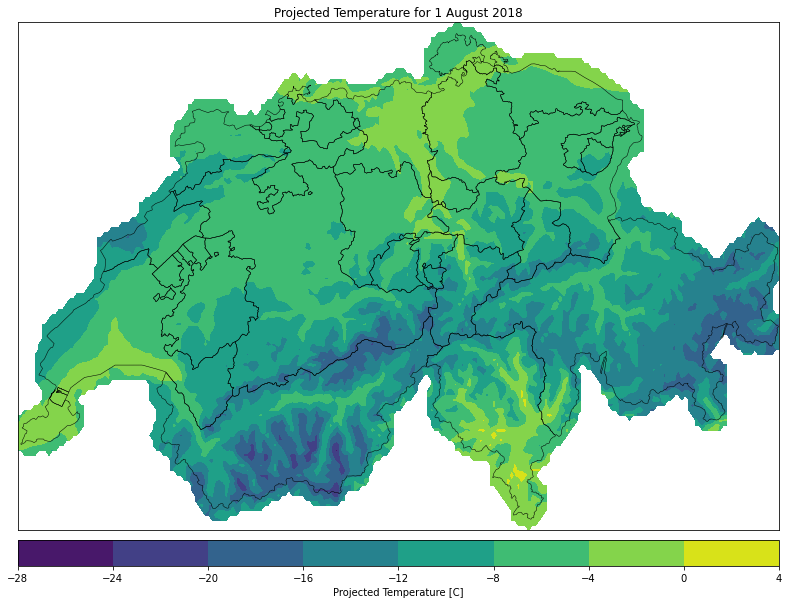

In [9]:
lat = temperature_ds["lat"][:]
min_lat = np.min(lat)
max_lat = np.max(lat)
lon = temperature_ds["lon"][:]
min_lon = np.min(lon)
max_lon = np.max(lon)

# Source code for this: https://www2.atmos.umd.edu/~cmartin/python/examples/netcdf_example1.html
plt.figure(figsize=(15, 10))
plt.title('Projected Temperature for 1 August 2018')
swiss_map = Basemap(projection='merc', llcrnrlon=min_lon, llcrnrlat=min_lat, urcrnrlon=max_lon, urcrnrlat=max_lat, resolution=None)

# Source for shapefile: https://geodata.lib.berkeley.edu/catalog/stanford-jn788wp9910 => might change this for swisstopo ones.
swiss_map.readshapefile('shapefiles/CHE_adm1', 'cantons')

# "Project" the longitude and latitude to get corresponding coordinates on the swiss_map
lons, lats = np.meshgrid(lon, lat)
x, y = swiss_map(lons, lats)

temp = swiss_map.contourf(x, y, temp_first_aug)
color_bar = swiss_map.colorbar(temp, "bottom")
color_bar.set_label("Projected Temperature [C]")